# MiDaSv3 Depth Estimation for YOLOv8 Detected Objects

In [ ]:
!pip install timm

In [106]:
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline
import torch
from ultralytics import YOLO

## Object Detection with YOLOv8

In [3]:
# Load a model
model = YOLO("yolov8n.pt")  # load a pre-trained model

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:01<00:00, 3.93MB/s]


In [114]:
images = glob("./assets/*.jpg")
images

['./assets/cyber.jpg',
 './assets/thrones_01.jpg',
 './assets/thrones_02.jpg',
 './assets/thrones_03.jpg',
 './assets/thrones_04.jpg',
 './assets/thrones_05.jpg',
 './assets/thrones_06.jpg']

In [287]:
# detect & track objects
results = model(images[6])


image 1/1 /opt/app/05_MiDaSv3_YOLOv8/assets/thrones_06.jpg: 640x448 1 person, 10.3ms
Speed: 13.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


In [288]:
# plot results
composed = results[0].plot()
composed_rgb = cv.cvtColor(composed, cv.COLOR_BGR2RGB)

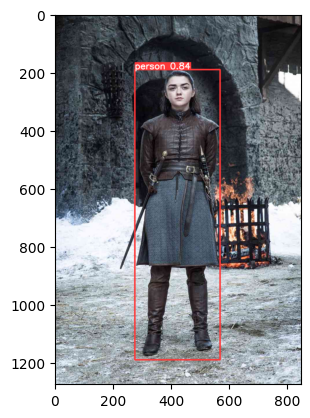

In [289]:
plt.imshow(composed_rgb)
# plt.axis('off')

In [317]:
pred_images = glob("assets/pred_*")

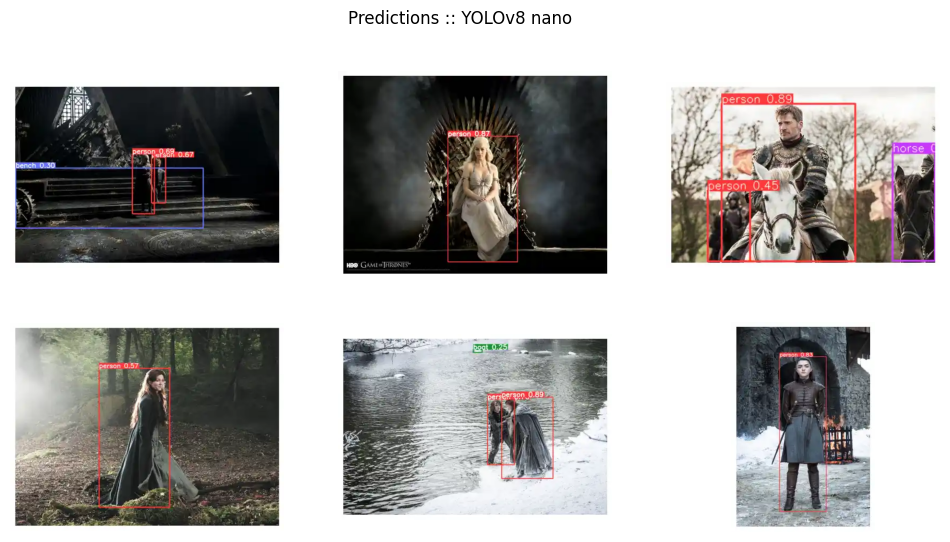

In [318]:
plt.figure(figsize=(12, 6))
plt.suptitle('Predictions :: YOLOv8 nano')

i = 0

for image_path in pred_images:
    ax = plt.subplot(2, 3, i+1)
    imgpred = plt.imread(image_path)
    plt.imshow(imgpred, cmap=plt.cm.binary)
    plt.axis(False)

    i += 1

### Draw Bounding Box

In [290]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8433], device='cuda:0')
data: tensor([[2.7479e+02, 1.9169e+02, 5.6796e+02, 1.1912e+03, 8.4332e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1275, 849)
shape: torch.Size([1, 6])
xywh: tensor([[421.3745, 691.4552, 293.1772, 999.5230]], device='cuda:0')
xywhn: tensor([[0.4963, 0.5423, 0.3453, 0.7839]], device='cuda:0')
xyxy: tensor([[ 274.7859,  191.6937,  567.9631, 1191.2167]], device='cuda:0')
xyxyn: tensor([[0.3237, 0.1503, 0.6690, 0.9343]], device='cuda:0')

In [291]:
# get coordinates of predicted bbox
boxes = results[0].boxes

for box in boxes:
    print(box.xyxy)

tensor([[ 274.7859,  191.6937,  567.9631, 1191.2167]], device='cuda:0')


In [292]:
# bbox start point
x1 = int(boxes[0].xyxy[0][0].tolist())
y1 = int(boxes[0].xyxy[0][1].tolist())
# bbox end point
x2 = int(boxes[0].xyxy[0][2].tolist())
y2 = int(boxes[0].xyxy[0][3].tolist())

In [295]:
# get image
test_image = plt.imread(images[6])

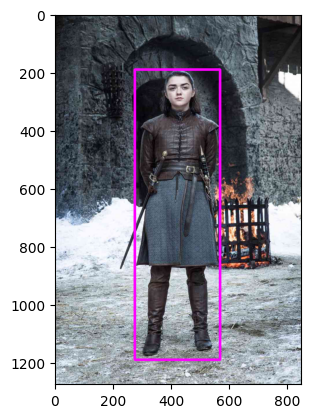

In [296]:
# draw a bounding box
result_image = cv.rectangle(test_image, (x1,y1), (x2,y2), (255,0,255), 7) 
# displaying the image  
plt.imshow(result_image)  

### Draw Center Point

In [297]:
# get bbox center cords
x_center, y_center = (((x2-x1)/2 + x1), ((y2-y1)/2 + y1))

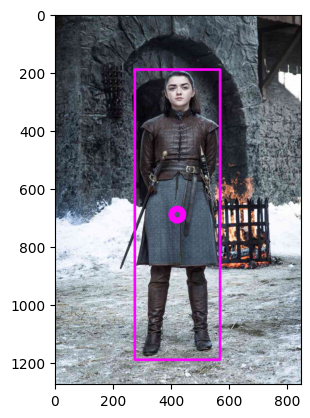

In [298]:
# draw center of box
result_image = cv.circle(test_image, (int(x_center), int(y_center)), 20, (255,0,255), 20)
# displaying the image  
plt.imshow(result_image)  

## MiDaSv3 Depth Estimation

In [ ]:
# downloading the Midas model from TorchHub.
#model_type = "DPT_Large"     # MiDaS v3 - Large (1.28GM) (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid (470M) (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small (82M) (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)

# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [134]:
# Use transforms to resize and normalize the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [299]:
imgbatch = transform(test_image).to(device)

# Making a prediction
with torch.no_grad():
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

output = prediction.cpu().numpy()

# normalizing the output predictions for cv2 to read.
output_norm = cv.normalize(output, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# colored depth map
output_norm_c = (output_norm*255).astype(np.uint8)
output_norm_c = cv.applyColorMap(output_norm_c, cv.COLORMAP_MAGMA)

Text(0.5, 1.0, 'Depth Map')

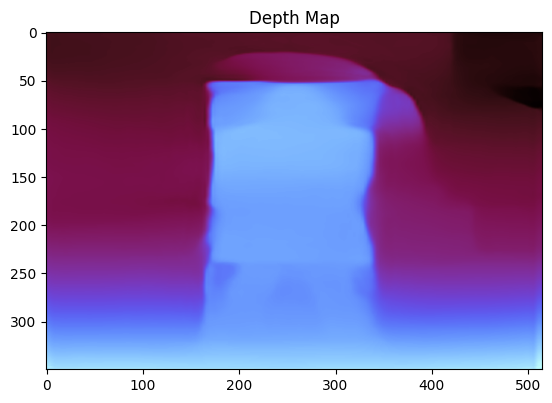

In [300]:
plt.imshow(output_norm_c, cmap=plt.cm.binary)
#plt.axis(False)
plt.title('Depth Map')

In [301]:
print('Max depth: ', output_norm.max(), ', Min depth: ', output_norm.min(), ', Mean depth: ', output_norm.mean())

Max depth:  1.0 , Min depth:  2.5929623e-09 , Mean depth:  0.48151022


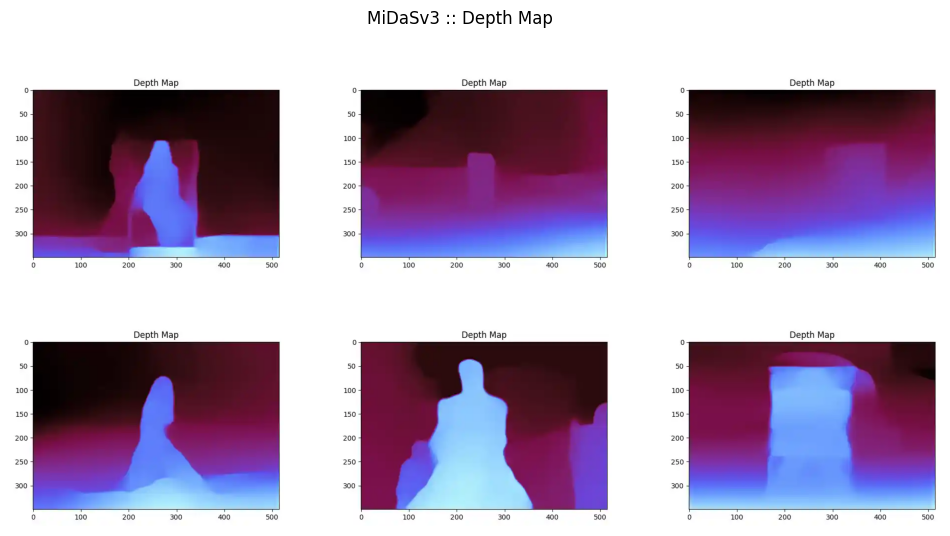

In [302]:
depth_images = glob("assets/depth*")

plt.figure(figsize=(12, 6))
plt.suptitle('MiDaSv3 :: Depth Map')

i = 0

for image_path in depth_images:
    ax = plt.subplot(2, 3, i+1)
    imgpred = plt.imread(image_path)
    plt.imshow(imgpred, cmap=plt.cm.binary)
    plt.axis(False)

    i += 1

## Get Depth Estimation for YOLO BBOX Center Point

In [303]:
# arrays from normed depth map
h , w = output_norm.shape
x_grid = np.arange(w)
y_grid = np.arange(h)

In [304]:
# create a spline object using the output_norm arrays
spline = RectBivariateSpline(y_grid, x_grid, output_norm)

In [305]:
#Define depth to distance
def depth_to_distance(depth_value,depth_scale):
    return 1.0 / (depth_value*depth_scale)

In [306]:
#Passing the x and y co-ordinates distance function to calculate distance.
#Tweak with the depth scale to see what suits you!
depth_scale = 1
depth_mid_filt = spline(x_center, y_center)
depth_midas = depth_to_distance(depth_mid_filt, depth_scale)

(-0.5, 848.5, 1274.5, -0.5)

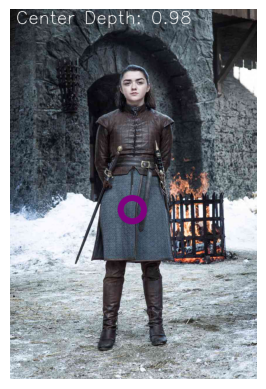

In [315]:
cv.putText(test_image, 'Center Depth: ' + str(np.format_float_positional(depth_mid_filt, precision=2)),(20,50),cv.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
cv.circle(test_image,(int(x_center), int(y_center)), 40, (128,0,128), 20)
plt.imshow(test_image, cmap=plt.cm.binary)
plt.axis(False)

In [311]:
# get image
test_image = plt.imread(images[6])

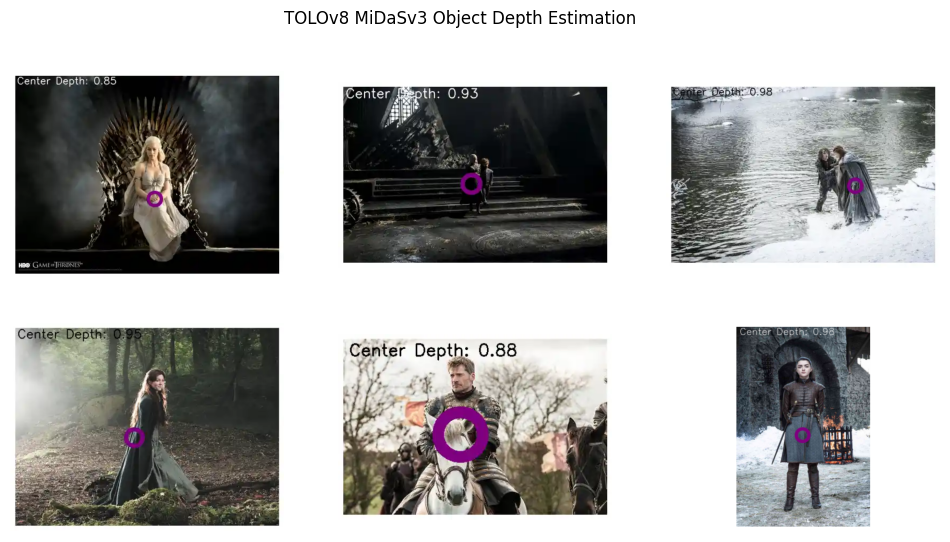

In [316]:
result_images = glob("assets/result*")

plt.figure(figsize=(12, 6))
plt.suptitle('TOLOv8 MiDaSv3 Object Depth Estimation')

i = 0

for image_path in result_images:
    ax = plt.subplot(2, 3, i+1)
    imgpred = plt.imread(image_path)
    plt.imshow(imgpred, cmap=plt.cm.binary)
    plt.axis(False)

    i += 1